In [426]:
import numpy as np # linear algebra -for numeric computations
import pandas as pd # data processing -to store data as dataframes 
import matplotlib.pyplot as plt # data visualization 
%matplotlib inline
import seaborn as sns # data visualization 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestRegressor
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import math

In [427]:
data = pd.read_csv("https://bit.ly/prosper-dataset")
data.head(7)

,ListingKey,ListingNumber,ListingCreationDate,CreditGrade,Term,LoanStatus,ClosedDate,BorrowerAPR,BorrowerRate,LenderYield,...,LP_ServiceFees,LP_CollectionFees,LP_GrossPrincipalLoss,LP_NetPrincipalLoss,LP_NonPrincipalRecoverypayments,PercentFunded,Recommendations,InvestmentFromFriendsCount,InvestmentFromFriendsAmount,Investors
0,1021339766868145413AB3B,193129,2007-08-26 19:09:29.263000000,C,36,Completed,2009-08-14 00:00:00,0.16516,0.1580,0.1380,...,-133.18,0.0,0.0,0.0,0.0,1.0,0,0,0.0,258
1,10273602499503308B223C1,1209647,2014-02-27 08:28:07.900000000,NaN,36,Current,NaN,0.12016,0.0920,0.0820,...,0.00,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
2,0EE9337825851032864889A,81716,2007-01-05 15:00:47.090000000,HR,36,Completed,2009-12-17 00:00:00,0.28269,0.2750,0.2400,...,-24.20,0.0,0.0,0.0,0.0,1.0,0,0,0.0,41
3,0EF5356002482715299901A,658116,2012-10-22 11:02:35.010000000,NaN,36,Current,NaN,0.12528,0.0974,0.0874,...,-108.01,0.0,0.0,0.0,0.0,1.0,0,0,0.0,158
4,0F023589499656230C5E3E2,909464,2013-09-14 18:38:39.097000000,NaN,36,Current,NaN,0.24614,0.2085,0.1985,...,-60.27,0.0,0.0,0.0,0.0,1.0,0,0,0.0,20
5,0F05359734824199381F61D,1074836,2013-12-14 08:26:37.093000000,NaN,60,Current,NaN,0.15425,0.1314,0.1214,...,-25.33,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1
6,0F0A3576754255009D63151,750899,2013-04-12 09:52:56.147000000,NaN,36,Current,NaN,0.31032,0.2712,0.2612,...,-22.95,0.0,0.0,0.0,0.0,1.0,0,0,0.0,1


In [428]:
# parsing Dates
data['ListingCreationDate'] = pd.to_datetime(data['ListingCreationDate'])
data['ClosedDate'] = pd.to_datetime(data['ClosedDate'])
data['DateCreditPulled'] = pd.to_datetime(data['DateCreditPulled'])
data['FirstRecordedCreditLine'] = pd.to_datetime(data['FirstRecordedCreditLine'])
data['LoanOriginationDate'] = pd.to_datetime(data['LoanOriginationDate'])


In [429]:
#  removing any feature with more than 75% of missing values.
data_with_less_missing_values = data.dropna(thresh=data.shape[0] * 0.25, axis=1)
data_with_less_missing_values.shape

(113937, 71)

In [430]:
# removing loan samples with have more than 20% of missing values
data_with_less_missing_values = data_with_less_missing_values.dropna(thresh=data.shape[1] * 0.80, axis=0).reset_index(drop=True)
data_with_less_missing_values.shape

(103360, 71)

In [431]:
cat_cols = [name for name in data_with_less_missing_values 
                        if data_with_less_missing_values[name].dtype in ["object", "bool" ]]
numerical_cols = [name for name in data_with_less_missing_values.columns
                      if data_with_less_missing_values[name].dtype in ['int64', 'float64', 'datetime64[ns]']]
cat_data = data_with_less_missing_values.drop(axis=1, columns=numerical_cols)
num_data = data_with_less_missing_values.drop(axis=1, columns=cat_cols)


In [432]:
cat_data.Occupation = cat_data.Occupation.fillna(cat_data.Occupation.mode().iloc[0])

In [433]:
cat_data = cat_data.drop(axis=1, columns=['ProsperRating (Alpha)'])

In [434]:
# all missing values in the CreditGrade column represents the rating value 0
# fill in nan values with letter Z and then use OrdinalEncoder to convert it to numerical values
cat_data.CreditGrade = cat_data.CreditGrade.fillna("Z")
from sklearn.preprocessing import OrdinalEncoder
ratings = ['Z', 'HR', 'E', 'D', 'C', 'B', 'A', 'AA']
encoder = OrdinalEncoder(categories = [ratings])
cat_data[['CreditGrade']] = encoder.fit_transform(cat_data[['CreditGrade']])
cat_data.CreditGrade = cat_data.CreditGrade.astype(int)

In [435]:
for column in cat_data.columns:
    print(f'{column} : {len(data[column].unique())}')

ListingKey : 113066
CreditGrade : 9
LoanStatus : 12
BorrowerState : 52
Occupation : 68
EmploymentStatus : 9
IsBorrowerHomeowner : 2
CurrentlyInGroup : 2
IncomeRange : 8
IncomeVerifiable : 2
LoanKey : 113066
LoanOriginationQuarter : 33
MemberKey : 90831


In [436]:
cat_data = cat_data.drop(columns=['LoanKey','MemberKey','ListingKey'],axis=1)

In [437]:
for column in cat_data.columns:
    print(f'{column} : {len(data[column].unique())}')

CreditGrade : 9
LoanStatus : 12
BorrowerState : 52
Occupation : 68
EmploymentStatus : 9
IsBorrowerHomeowner : 2
CurrentlyInGroup : 2
IncomeRange : 8
IncomeVerifiable : 2
LoanOriginationQuarter : 33


In [438]:
cat_data.isna().sum()

CreditGrade               0
LoanStatus                0
BorrowerState             0
Occupation                0
EmploymentStatus          0
IsBorrowerHomeowner       0
CurrentlyInGroup          0
IncomeRange               0
IncomeVerifiable          0
LoanOriginationQuarter    0
dtype: int64

In [439]:
num_data.isna().sum()

ListingNumber                             0
ListingCreationDate                       0
Term                                      0
ClosedDate                            58848
BorrowerAPR                               0
BorrowerRate                              0
LenderYield                               0
EstimatedEffectiveYield               18507
EstimatedLoss                         18507
EstimatedReturn                       18507
ProsperRating (numeric)               18507
ProsperScore                          18507
ListingCategory (numeric)                 0
EmploymentStatusDuration                 19
DateCreditPulled                          0
CreditScoreRangeLower                     0
CreditScoreRangeUpper                     0
FirstRecordedCreditLine                   0
CurrentCreditLines                        0
OpenCreditLines                           0
TotalCreditLinespast7years                0
OpenRevolvingAccounts                     0
OpenRevolvingMonthlyPayment     

In [440]:
num_data['DebtToIncomeRatio'].fillna(value=num_data['DebtToIncomeRatio'].median(), inplace=True)

In [441]:
plt.figure(figsize=(45,10))
num_data.EmploymentStatusDuration = num_data.EmploymentStatusDuration.fillna(num_data.EmploymentStatusDuration.mode().iloc[0])

<Figure size 3240x720 with 0 Axes>

In [442]:
num_data.ClosedDate.fillna(value='Not Closed', inplace=True)

In [443]:
num_data.isna().sum()

ListingNumber                             0
ListingCreationDate                       0
Term                                      0
ClosedDate                                0
BorrowerAPR                               0
BorrowerRate                              0
LenderYield                               0
EstimatedEffectiveYield               18507
EstimatedLoss                         18507
EstimatedReturn                       18507
ProsperRating (numeric)               18507
ProsperScore                          18507
ListingCategory (numeric)                 0
EmploymentStatusDuration                  0
DateCreditPulled                          0
CreditScoreRangeLower                     0
CreditScoreRangeUpper                     0
FirstRecordedCreditLine                   0
CurrentCreditLines                        0
OpenCreditLines                           0
TotalCreditLinespast7years                0
OpenRevolvingAccounts                     0
OpenRevolvingMonthlyPayment     

# added new

In [444]:
num_data['EstimatedEffectiveYield'].fillna(value=num_data['EstimatedEffectiveYield'].median(), inplace=True)
num_data['EstimatedLoss'].fillna(value=num_data['EstimatedLoss'].median(), inplace=True)
num_data['EstimatedReturn'].fillna(value=num_data['EstimatedReturn'].median(), inplace=True)
num_data['ProsperRating (numeric)'].fillna(value=num_data['ProsperRating (numeric)'].median(), inplace=True)
num_data['ProsperScore'].fillna(value=num_data['ProsperScore'].median(), inplace=True)

In [445]:
num_data.isna().sum()

ListingNumber                         0
ListingCreationDate                   0
Term                                  0
ClosedDate                            0
BorrowerAPR                           0
BorrowerRate                          0
LenderYield                           0
EstimatedEffectiveYield               0
EstimatedLoss                         0
EstimatedReturn                       0
ProsperRating (numeric)               0
ProsperScore                          0
ListingCategory (numeric)             0
EmploymentStatusDuration              0
DateCreditPulled                      0
CreditScoreRangeLower                 0
CreditScoreRangeUpper                 0
FirstRecordedCreditLine               0
CurrentCreditLines                    0
OpenCreditLines                       0
TotalCreditLinespast7years            0
OpenRevolvingAccounts                 0
OpenRevolvingMonthlyPayment           0
InquiriesLast6Months                  0
TotalInquiries                        0


In [446]:
num_data.select_dtypes(include=('object'))

,ClosedDate
0,2009-08-14 00:00:00
1,Not Closed
2,Not Closed
3,Not Closed
4,Not Closed
...,...
103355,Not Closed
103356,Not Closed
103357,Not Closed
103358,2013-08-13 00:00:00


In [447]:
num_data['ClosedDate'] = num_data['ClosedDate'].fillna(0)
num_data['ClosedDate'] = num_data['ClosedDate'].apply(lambda x:1 if x!='Not Closed' else 0)

In [448]:
num_data.ClosedDate

0         1
1         0
2         0
3         0
4         0
         ..
103355    0
103356    0
103357    0
103358    1
103359    0
Name: ClosedDate, Length: 103360, dtype: int64

In [449]:
modified_data = num_data.join(cat_data)

In [450]:
modified_data.select_dtypes(include=('bool')).columns

Index(['IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable'], dtype='object')

In [451]:
bools = ['IsBorrowerHomeowner', 'CurrentlyInGroup', 'IncomeVerifiable']
for i in bools:
    modified_data[i] = modified_data[i].apply(lambda x:1 if x else 0)

In [452]:
modified_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103360 entries, 0 to 103359
Data columns (total 67 columns):
 #   Column                              Non-Null Count   Dtype         
---  ------                              --------------   -----         
 0   ListingNumber                       103360 non-null  int64         
 1   ListingCreationDate                 103360 non-null  datetime64[ns]
 2   Term                                103360 non-null  int64         
 3   ClosedDate                          103360 non-null  int64         
 4   BorrowerAPR                         103360 non-null  float64       
 5   BorrowerRate                        103360 non-null  float64       
 6   LenderYield                         103360 non-null  float64       
 7   EstimatedEffectiveYield             103360 non-null  float64       
 8   EstimatedLoss                       103360 non-null  float64       
 9   EstimatedReturn                     103360 non-null  float64       
 10  ProsperR

In [453]:
# modified_data.to_csv('cleaned.csv',index=True)

In [454]:
modified_data = modified_data.drop(["ListingCreationDate","DateCreditPulled","FirstRecordedCreditLine","LoanOriginationDate","LoanOriginationQuarter","ListingNumber","LoanNumber"],axis=1)

In [455]:
# Selected those features according to the output of RandomForestClassifier importance function
modified_data = modified_data[["ClosedDate","LoanCurrentDaysDelinquent","LoanMonthsSinceOrigination","LP_CustomerPrincipalPayments","LP_GrossPrincipalLoss","LP_NetPrincipalLoss","LP_CustomerPayments","EmploymentStatus","LP_ServiceFees","LoanOriginalAmount","Investors","EstimatedReturn","LP_InterestandFees","MonthlyLoanPayment","LP_CollectionFees","EstimatedEffectiveYield","EstimatedLoss","Term","BorrowerAPR","LP_NonPrincipalRecoverypayments","BorrowerRate","ListingCategory (numeric)","LenderYield","CreditScoreRangeUpper","OpenRevolvingMonthlyPayment","ProsperScore","CreditScoreRangeLower","RevolvingCreditBalance","ProsperRating (numeric)","AvailableBankcardCredit","EmploymentStatusDuration","DebtToIncomeRatio","StatedMonthlyIncome","BankcardUtilization","TotalCreditLinespast7years","TotalTrades","LoanStatus"]]

y = modified_data["LoanStatus"]
X = modified_data.drop(["LoanStatus"],axis=1)
label_encoding_cols=["EmploymentStatus"]
for i in label_encoding_cols:
    X[i]=X[i].astype("category")
    X[i]=X[i].cat.codes

In [456]:
x_train, x_test,y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=0)
rf = RandomForestClassifier(n_estimators = 300,random_state = 1, max_depth=30,n_jobs=-1)
rf.fit(x_train,y_train)
rf_pred=rf.predict(x_test)

results = list(zip(X, rf.feature_importances_))
importance = pd.DataFrame(results, columns = ["Feature", "Importance"])
importance = importance.sort_values(by="Importance", ascending=False)
importance

,Feature,Importance
0,ClosedDate,0.306856
1,LoanCurrentDaysDelinquent,0.134372
2,LoanMonthsSinceOrigination,0.116352
3,LP_CustomerPrincipalPayments,0.090534
4,LP_GrossPrincipalLoss,0.069816
5,LP_NetPrincipalLoss,0.063550
6,LP_CustomerPayments,0.034277
7,EmploymentStatus,0.023510
8,LP_ServiceFees,0.016366
10,Investors,0.016258


In [457]:
importance.to_csv("importance.csv",index=False)

In [458]:
print("---------------------------------------------------------------------")
print("Accuracy Score for Random Forest :",accuracy_score(y_test,rf_pred))
print("---------------------------------------------------------------------")
print("\n")
print("classification stats for Random Forest Classifier :\n\n",classification_report(y_test, rf_pred))
print("---------------------------------------------------------------------")

---------------------------------------------------------------------
Accuracy Score for Random Forest : 0.9868421052631579
---------------------------------------------------------------------




/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


classification stats for Random Forest Classifier :

                         precision    recall  f1-score   support

            Chargedoff       0.92      0.99      0.95      1993
             Completed       1.00      1.00      1.00      6336
               Current       1.00      1.00      1.00     11267
             Defaulted       0.96      0.70      0.81       594
FinalPaymentInProgress       1.00      0.05      0.10        39
  Past Due (1-15 days)       0.95      1.00      0.98       167
 Past Due (16-30 days)       0.96      0.75      0.84        63
 Past Due (31-60 days)       0.83      0.94      0.88        72
 Past Due (61-90 days)       0.87      0.86      0.86        70
Past Due (91-120 days)       0.91      0.90      0.91        69
  Past Due (>120 days)       0.00      0.00      0.00         2

              accuracy                           0.99     20672
             macro avg       0.85      0.74      0.76     20672
          weighted avg       0.99      0.99     

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


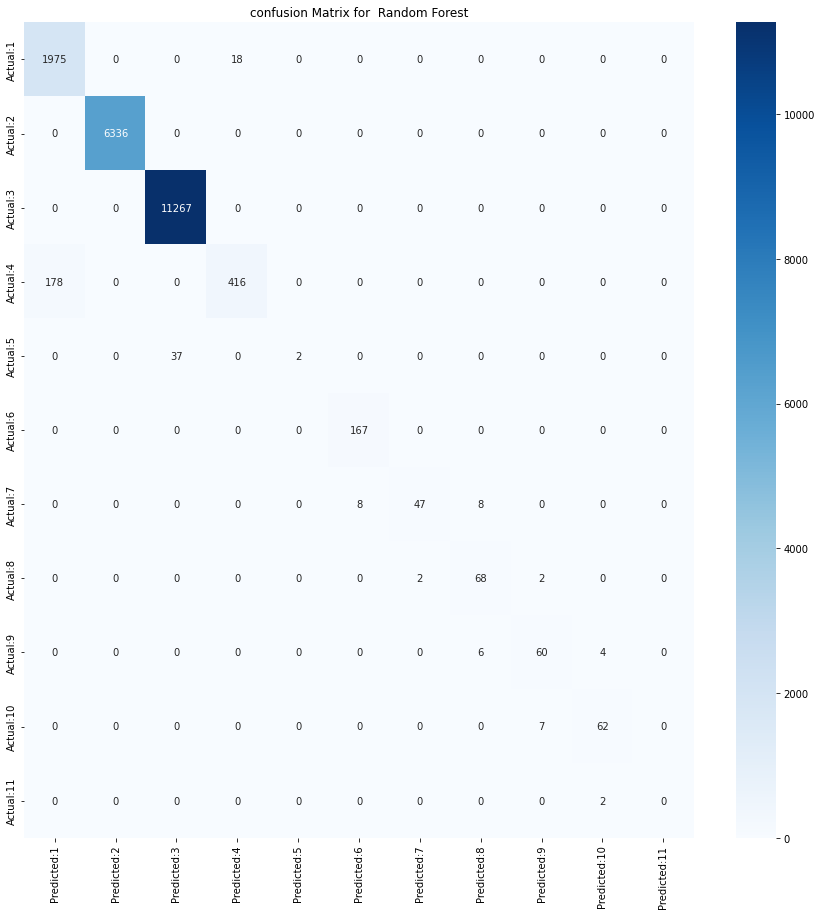

In [459]:
cm=confusion_matrix(y_test,rf_pred)
conf_matrix=pd.DataFrame(data=cm,columns=['Predicted:1','Predicted:2','Predicted:3','Predicted:4','Predicted:5','Predicted:6','Predicted:7','Predicted:8','Predicted:9','Predicted:10','Predicted:11'],
                                         index=['Actual:1','Actual:2','Actual:3','Actual:4','Actual:5','Actual:6','Actual:7','Actual:8','Actual:9','Actual:10','Actual:11'])                          
plt.figure(figsize = (15,15))
sns.heatmap(conf_matrix, annot=True,fmt='d',cmap='Blues')
plt.title("confusion Matrix for  Random Forest")
plt.show()

In [460]:
y = modified_data["BorrowerRate"]
X = modified_data.drop(["BorrowerRate"],axis=1)
label_encoding_cols=["EmploymentStatus","LoanStatus"]
for i in label_encoding_cols:
    X[i]=X[i].astype("category")
    X[i]=X[i].cat.codes

In [461]:
x_train, x_test,y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state=0)
rf = RandomForestRegressor(n_estimators = 300,random_state = 1, max_depth=30,n_jobs=-1)
rf.fit(x_train,y_train)
rf_pred=rf.predict(x_test)

In [462]:
RMSE = math.sqrt(mean_squared_error(y_test,rf_pred))
print('RMSE:'+str(RMSE))
MAE = mean_absolute_error(y_test,rf_pred)
print('MAE:'+str(MAE))

RMSE:0.0008347852165516918
MAE:0.00012737656411312463
